## Load libraries

In [1]:
from torch import nn
from torch import optim
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision
import time
from sklearn.metrics import confusion_matrix

## Define training and test sets

In [2]:
Type="TRAINING"
exec(open("../helperFunctions.py","rb").read())

Select classes to use for training:


Checkbox(value=False, description='Dogs', indent=False)

Checkbox(value=False, description='Cats', indent=False)

Checkbox(value=False, description='Birds', indent=False)

In [3]:
UsedClasses=[]
for k in widgetDict:
    if widgetDict[k].value==True:
        UsedClasses.append(k)
if(len(UsedClasses)<2):
    print("Something is wrong here. we need at least 2 classes!")

## Loading data set
If test set is not defined previously, this function pulls a test set from the training set using a 80/20%split

In [4]:
classes = tuple(UsedClasses)

transform = transforms.Compose(
    [transforms.Resize(224),
    transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainSets=[]
testSets=[]

for cl in UsedClasses:
    trainPath=os.path.join(SPECTRUM_IMAGES_ROOT,cl,'train')
    if os.path.isdir (trainPath):
        trainSets.append(SpectrumDataset(classes.index(cl),trainPath,transform))
    else:
        print('Coud not find path',trainPath);
    
    testPath=os.path.join(SPECTRUM_IMAGES_ROOT,cl,'test')
    if os.path.isdir (testPath):
        testSets.append(SpectrumDataset(classes.index(cl),testPath,transform))
    else:
        print('Coud not find path',testPath);

        
print(trainSets,testSets)

TrainDataSet = torch.utils.data.ConcatDataset(trainSets)
TestDataSet = torch.utils.data.ConcatDataset(testSets)

trainloader = torch.utils.data.DataLoader(TrainDataSet, batch_size=16, shuffle=True)
testloader = torch.utils.data.DataLoader(TestDataSet, batch_size=16, shuffle=False)



../GeneratedData/Dogs/train 3860
../GeneratedData/Dogs/test 850
../GeneratedData/Cats/train 3956
../GeneratedData/Cats/test 1911
[<__main__.SpectrumDataset object at 0x13fbdbb90>, <__main__.SpectrumDataset object at 0x13fbdbcd0>] [<__main__.SpectrumDataset object at 0x13f4e9a10>, <__main__.SpectrumDataset object at 0x13fbdbd90>]


## Preview sample training images

The following cell takes an entire training batch of images and displays them with their respective labels. Have a look and verify that indeed you see spectrograph images that look similar to what you saw earlier.

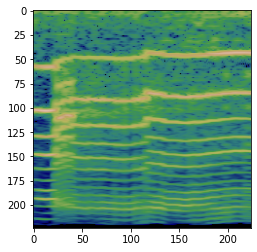

Cats


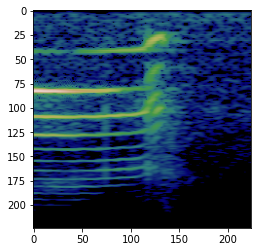

Cats


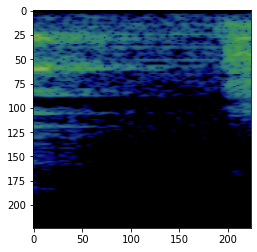

Cats


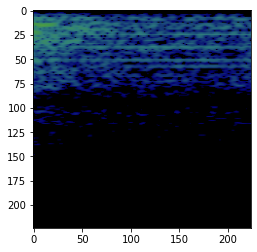

Cats


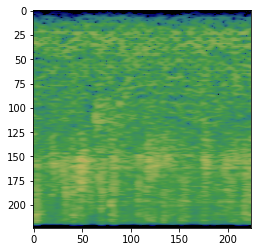

Cats


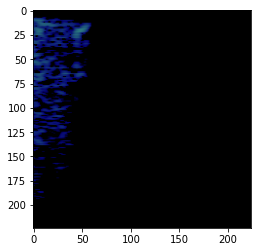

Cats


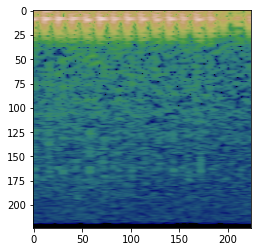

Cats


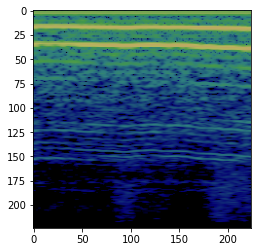

Cats


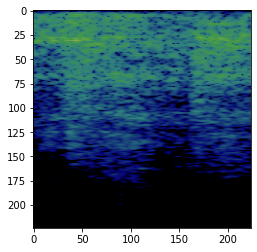

Dogs


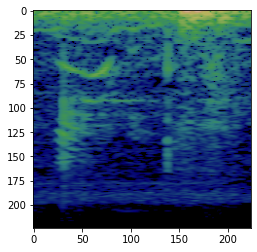

Dogs


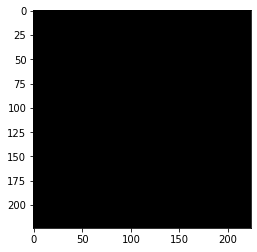

Cats


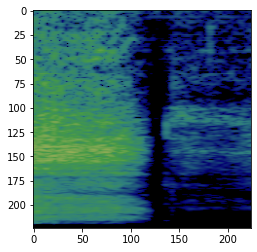

Cats


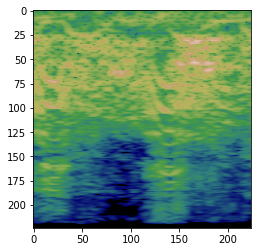

Dogs


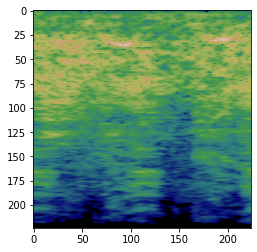

Dogs


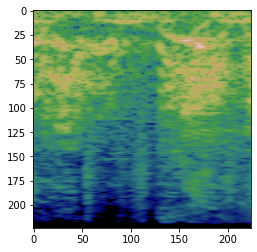

Dogs


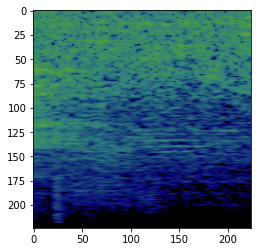

Dogs


In [9]:
#Getting some random training images and showing them
dataiter = iter(trainloader)
images, labels = dataiter.next()
for i in range(trainloader.batch_size):
    imshow(images[i])
    print(classes[labels[i]])

## Specify use of Graphics Card (if there is one) and use ResNet

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)


## Load pretrained model 
The model '../Models/MainModelUrban.pth' was trained on the UrbanSound dataset; other models could be specified instead.

In [12]:
ModelData = torch.load('../Models/MainModelUrban.pth',map_location='cpu')
model.load_state_dict(ModelData['model'])

<All keys matched successfully>

## Cutting off the head
In the following cell, the setting 'param.requires_grad = False' is **the** function that is telling the network to only retrain the last layer. If you set this parameter to True, the training will take much longer, but hopefully be better at predicting. 

In [21]:
for param in model.parameters():
    param.requires_grad = False
model.fc = nn.Linear(512, len(classes)) # otherwise change it 

## Move model to GPU (if there is a GPU)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
train_epoch_losses=[]
test_epoch_losses=[]
epoch=0

device is cpu


## Training the network

In [15]:
#Training the network on the training dataset
for i in range(5):  # loop over the dataset multiple (5) times 
    epoch+=1
    print("Starting epoch:",epoch)
    epochLoss=0.0
    t0 = time.time()
    model.train()
    for i, data in enumerate(trainloader, 0):
        #print("Running Batches",i)
        # get the inputs
        inputs, labels = data
        if device.type=='cuda':
            inputs, labels = inputs.to(device), labels.to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        if((i+i)%200==0):
            if(i>0):
                print('Processed images:',i*trainloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))
        # forward + backward + optimize
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        epochLoss+=loss.item()
        
    
    model.eval()
    testLoss=0
    print("About to test the performance on the test set.")
    with torch.no_grad():
        for i, data in enumerate(testloader, 0):
            # get the inputs
            inputs, labels = data
            if device.type=='cuda':
                inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            testLoss+=loss.item()
            if(i%50==0):
                if(i>0):
                    print('Tested images:',i*testloader.batch_size,'. Running Timer @ {:.2f}sec.'.format(time.time()-t0))


    train_epoch_losses.append(epochLoss/len(trainloader))
    test_epoch_losses.append(testLoss/len(testloader))
    EpochLength = time.time()-t0
    print('{} train loss: {:.3f} and test loss: {:.3f}, and it took us: {:.2f} seconds.'.format (epoch + 1, epochLoss / len(trainloader),testLoss/len(testloader),EpochLength))  # DAVID CHanged it to 1000 from 2000 not sure if thats totally done
print('Finished Training')


Starting epoch: 1
Processed images: 1600 . Running Timer @ 97.68sec.
Processed images: 3200 . Running Timer @ 196.67sec.
Processed images: 4800 . Running Timer @ 296.54sec.
Processed images: 6400 . Running Timer @ 397.09sec.
About to test the performance on the test set.
Tested images: 800 . Running Timer @ 526.73sec.
Tested images: 1600 . Running Timer @ 572.61sec.
Tested images: 2400 . Running Timer @ 613.87sec.
2 train loss: 0.395 and test loss: 0.461, and it took us: 632.19 seconds.
Starting epoch: 2


KeyboardInterrupt: 

## Post training analytics

After the training has finished, save information about the training

In [22]:
# saving the learnd model in file that can be loaded in for inference
torch.save({
    'model':model.state_dict(),
    'classes':classes,
    'resolution':224,
    'modelType':"resnet18" # <= If you try out different models make sure to change this too
},"../models/CatDogResNet.pth") # <=Edit file name here 

In [17]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

Display how the traing and test loss progressed over successive epochs

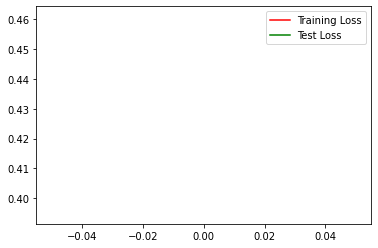

In [16]:
#Displaying how the loss progresses over time.
plt.plot(train_epoch_losses, label='Training Loss',c='r')
plt.plot(test_epoch_losses, label='Test Loss',c='g')
plt.legend()
plt.show()

Show spectagrams, Predicted and Actual labels.

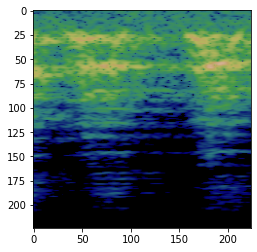

GroundTruth:  Dogs
Predicted:  Dogs


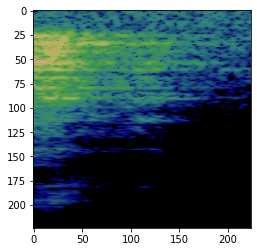

GroundTruth:  Dogs
Predicted:  Dogs


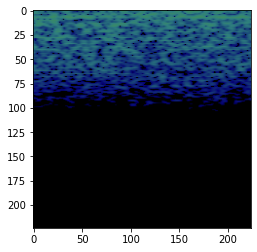

GroundTruth:  Dogs
Predicted:  Dogs


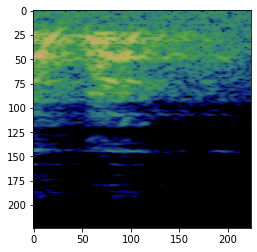

GroundTruth:  Dogs
Predicted:  Dogs


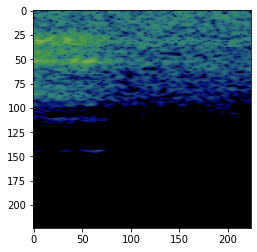

GroundTruth:  Dogs
Predicted:  Dogs


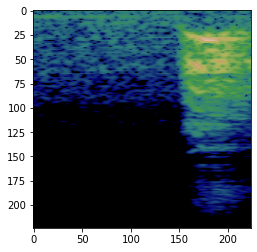

GroundTruth:  Dogs
Predicted:  Dogs


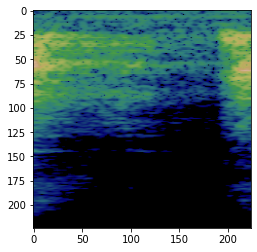

GroundTruth:  Dogs
Predicted:  Dogs


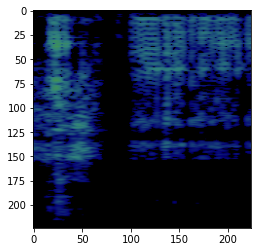

GroundTruth:  Dogs
Predicted:  Cats


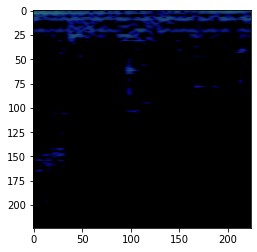

GroundTruth:  Dogs
Predicted:  Cats


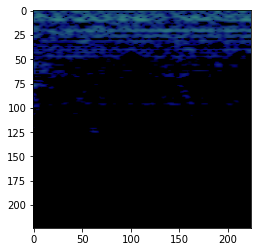

GroundTruth:  Dogs
Predicted:  Cats


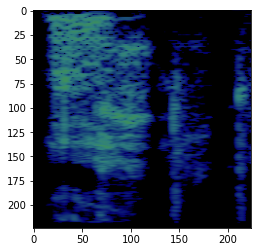

GroundTruth:  Dogs
Predicted:  Cats


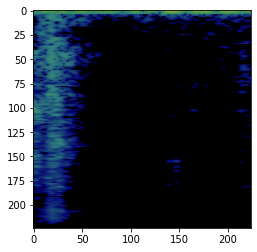

GroundTruth:  Dogs
Predicted:  Cats


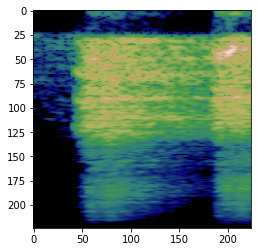

GroundTruth:  Dogs
Predicted:  Dogs


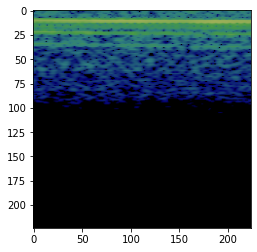

GroundTruth:  Dogs
Predicted:  Cats


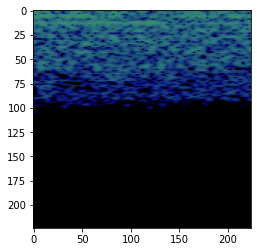

GroundTruth:  Dogs
Predicted:  Cats


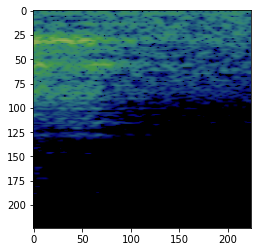

GroundTruth:  Dogs
Predicted:  Dogs


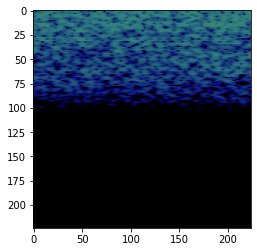

GroundTruth:  Dogs
Predicted:  Cats


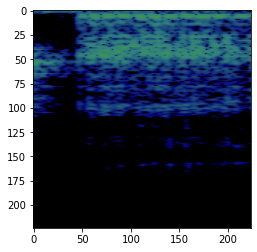

GroundTruth:  Dogs
Predicted:  Dogs


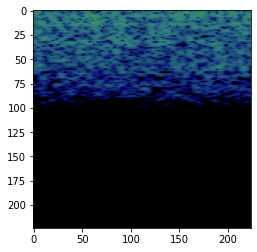

GroundTruth:  Dogs
Predicted:  Dogs


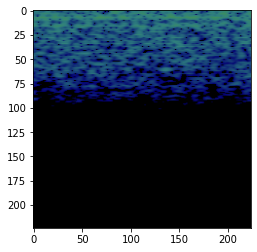

GroundTruth:  Dogs
Predicted:  Dogs


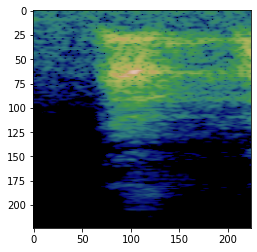

GroundTruth:  Dogs
Predicted:  Dogs


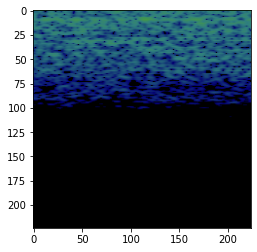

GroundTruth:  Dogs
Predicted:  Dogs


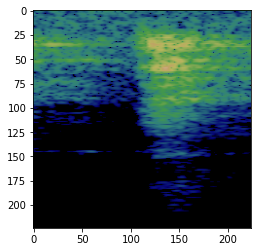

GroundTruth:  Dogs
Predicted:  Dogs


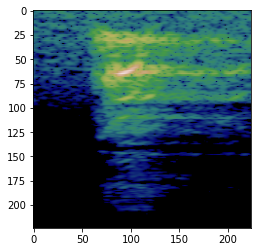

GroundTruth:  Dogs
Predicted:  Dogs


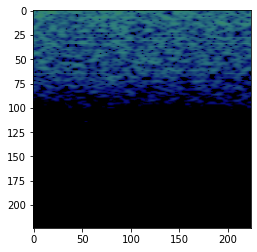

GroundTruth:  Dogs
Predicted:  Dogs


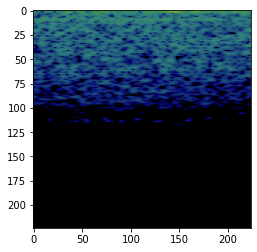

GroundTruth:  Dogs
Predicted:  Cats


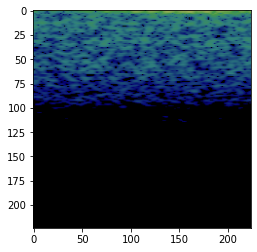

GroundTruth:  Dogs
Predicted:  Cats


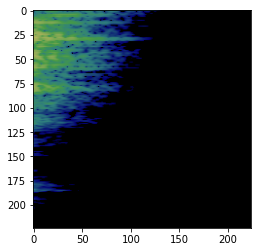

GroundTruth:  Dogs
Predicted:  Cats


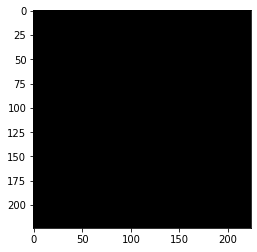

GroundTruth:  Dogs
Predicted:  Cats


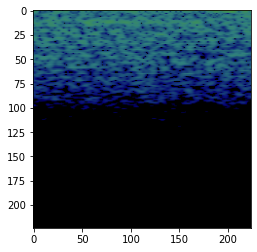

GroundTruth:  Dogs
Predicted:  Cats


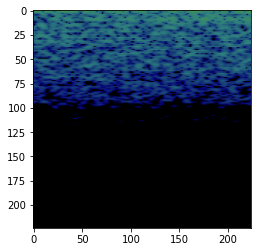

GroundTruth:  Dogs
Predicted:  Cats


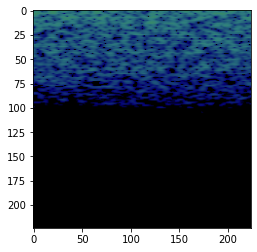

GroundTruth:  Dogs
Predicted:  Dogs


In [18]:
# Print predicted and acual labels for Spectragrams
dataiter = iter(testloader)
model.eval()
for j in range (2):
    images, labels = dataiter.next()
    if device == 'cuda':
        images, labels = images.to(device), labels.to(device)
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    for i in range(len(images)):
        imshow(images[i])
        print('GroundTruth: ',classes[labels[i]])
        print('Predicted: ',  classes[predicted[i]])


Print accuracy of test predictions for each label

In [19]:
# Network analytics
class_correct = list(0. for i in range(len(classes)))
class_total = list(0. for i in range(len(classes)))
model.eval()
allLabels=[]
allPrediction=[]
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        if (c.dim()==0):
            continue
        for i in range(testloader.batch_size):
            if(len(labels)<=i):
                continue;
            label = labels[i]
            allLabels.append(labels[i].to('cpu').numpy())
            allPrediction.append(predicted[i].to('cpu').numpy())
            #print (c.shape)
            if(testloader.batch_size>1):

                class_correct[label] += c[i].item()
            else:
                class_correct[label] += c.item()
            class_total[label] += 1

print(confusion_matrix(allLabels, allPrediction))
for i in range(len(classes)):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

[[ 610  240]
 [ 158 1753]]
Accuracy of  Dogs : 71 %
Accuracy of  Cats : 91 %


5 Epoch:
[[2126 1362]
 [ 426 4373]]
Accuracy of  Dogs : 60 %
Accuracy of  Cats : 91 %